## 04. モデル評価と推論エンジンの実装

このノートブックの目的:
1. `03_model_training`で学習・保存したモデルの重みをロードする。
2. **推薦エンジンの実装**: 全アイテムのベクトルを計算し、`FAISS`を用いて高速な類似アイテム検索インデックスを構築・保存する。
3. **定性的評価**: 構築したFAISSインデックスを使い、特定のアイテムについて類似アイテムを推薦させ、結果が直感的か目視で確認する。

### 1. 準備：ライブラリとデータの読み込み

In [1]:
import time
import pickle
import os
from typing import List, Dict, Any
from IPython.display import display, Markdown
import random

import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, util
import rtdl
import faiss
import umap
import matplotlib.pyplot as plt
import google.generativeai as genai

In [2]:
# --- デバイスの設定 ---
if torch.cuda.is_available():
    print("GPU is available!")
    print("Device Name:", torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print("GPU is not available. Using CPU.")
    device = torch.device("cpu")

GPU is available!
Device Name: NVIDIA GeForce GTX 1050 with Max-Q Design


In [3]:
# --- 定数とパスの定義 ---
TMP_DATA_DIR = 'tmp_data/'
MODEL_PATH = 'tmp_data/03_ftt_instacart_recommender/'
MODEL_WEIGHTS_PATH = os.path.join(MODEL_PATH, "pytorch_model.bin")

SCALED_PROFILES_PATH = os.path.join(TMP_DATA_DIR, '02_item_profiles_scaled.csv')
ORIGINAL_PROFILES_PATH = os.path.join(TMP_DATA_DIR, '01_item_profiles.csv') 

ITEM_VECTORS_PATH = os.path.join(TMP_DATA_DIR, '04_item_vectors.npy')
FAISS_INDEX_PATH = os.path.join(TMP_DATA_DIR, '04_faiss.index')

### 2. モデルの再構築と学習済み重みのロード

In [4]:
class TabularFTTransformer(nn.Module):
    def __init__(self, ft_transformer_model: nn.Module, numerical_feature_names: List[str], categorical_feature_names: List[str]):
        super().__init__()
        self.ft_transformer, self.numerical_feature_names, self.categorical_feature_names = ft_transformer_model, numerical_feature_names, categorical_feature_names
    def tokenize(self, item_feature_dicts: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        x_num = torch.tensor([[item.get(feat, 0.0) for feat in self.numerical_feature_names] for item in item_feature_dicts], dtype=torch.float32)
        x_cat = torch.tensor([[int(item.get(feat, 0)) for feat in self.categorical_feature_names] for item in item_feature_dicts], dtype=torch.long)
        return {'x_num': x_num, 'x_cat': x_cat}
    def forward(self, features: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        embeddings = self.ft_transformer(features['x_num'], features['x_cat'])
        return {'sentence_embedding': embeddings}
    def get_sentence_embedding_dimension(self) -> int:
        return self.ft_transformer.d_out

In [5]:
item_profiles_df = pd.read_csv(SCALED_PROFILES_PATH)
numerical_feature_names = ['reorder_rate', 'avg_add_to_cart_order', 'total_orders', 'unique_users', 'avg_days_since_prior_order']
categorical_feature_names = ['aisle_id', 'department_id']
cat_cardinalities = [int(item_profiles_df[col].max()) + 1 for col in categorical_feature_names]
D_OUT = 64

core_ft_transformer = rtdl.FTTransformer.make_default(n_num_features=len(numerical_feature_names), cat_cardinalities=cat_cardinalities, last_layer_query_idx=[-1], d_out=D_OUT)
ftt_wrapper = TabularFTTransformer(ft_transformer_model=core_ft_transformer, numerical_feature_names=numerical_feature_names, categorical_feature_names=categorical_feature_names)
model = SentenceTransformer(modules=[ftt_wrapper])

model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=device))
model.to(device)
model.eval()

print("モデルアーキテクチャを再構築し、学習済み重みをロードしました。")

モデルアーキテクチャを再構築し、学習済み重みをロードしました。


### 3. 全アイテムのベクトル化とFAISSインデックスの構築

#### 3-1. エンコードループの実装

In [6]:
# --- データ準備 ---
scaled_profiles_df = pd.read_csv(SCALED_PROFILES_PATH)
all_item_features = [row.to_dict() for index, row in scaled_profiles_df.iterrows()]
all_product_ids = [int(f['product_id']) for f in all_item_features]

# 推論用のシンプルなデータセットクラス
class InferenceDataset(Dataset):
    def __init__(self, features: List[Dict[str, Any]]):
        self.features = features
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx]

# 推論用のcollate_fn
def inference_collate_fn(batch_dicts):
    return model[0].tokenize(batch_dicts)

inference_dataset = InferenceDataset(all_item_features)
inference_dataloader = DataLoader(
    inference_dataset,
    batch_size=1024,
    shuffle=False, 
    collate_fn=inference_collate_fn,
    num_workers=2,
    pin_memory=True
)

In [7]:
# --- エンコードループ ---
all_embeddings_list = []
with torch.no_grad():
    for batch in tqdm(inference_dataloader, desc="全アイテムをベクトル化中"):
        batch_on_device = {key: val.to(device) for key, val in batch.items()}
        embeddings = model(batch_on_device)['sentence_embedding']
        all_embeddings_list.append(embeddings.cpu())

all_item_embeddings = torch.cat(all_embeddings_list).numpy()
print(f"ベクトル化が完了。ベクトル行列の形状: {all_item_embeddings.shape}")

np.save(ITEM_VECTORS_PATH, all_item_embeddings)

全アイテムをベクトル化中: 100%|██████████| 49/49 [00:01<00:00, 25.80it/s]

ベクトル化が完了。ベクトル行列の形状: (49688, 64)


#### 3-2. FAISSインデックスの構築と保存

In [8]:
# FAISSインデックスの構築
embedding_dim = all_item_embeddings.shape[1]
index = faiss.IndexFlatIP(embedding_dim)

# ベクトルの正規化
faiss.normalize_L2(all_item_embeddings)

# インデックスにベクトルを追加
index.add(all_item_embeddings)
print(f"FAISSインデックスの構築が完了しました。インデックス内のベクトル数: {index.ntotal}")

faiss.write_index(index, FAISS_INDEX_PATH)
print(f"インデックスを '{FAISS_INDEX_PATH}' に保存しました。")

FAISSインデックスの構築が完了しました。インデックス内のベクトル数: 49688
インデックスを 'tmp_data/04_faiss.index' に保存しました。


### 4. ベクトル空間の可視化 (UMAP)

In [9]:
# --- 準備 ---
index = faiss.read_index(FAISS_INDEX_PATH)
all_item_embeddings = np.load(ITEM_VECTORS_PATH)
original_profiles_df = pd.read_csv(ORIGINAL_PROFILES_PATH)

# product_idと各種インデックスのマッピングを作成
product_id_to_name = pd.Series(original_profiles_df.product_name.values, index=original_profiles_df.product_id).to_dict()
product_id_to_faiss_idx = {pid: i for i, pid in enumerate(all_product_ids)}
faiss_idx_to_product_id = {i: pid for i, pid in enumerate(all_product_ids)}

/opt/python/3.10/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


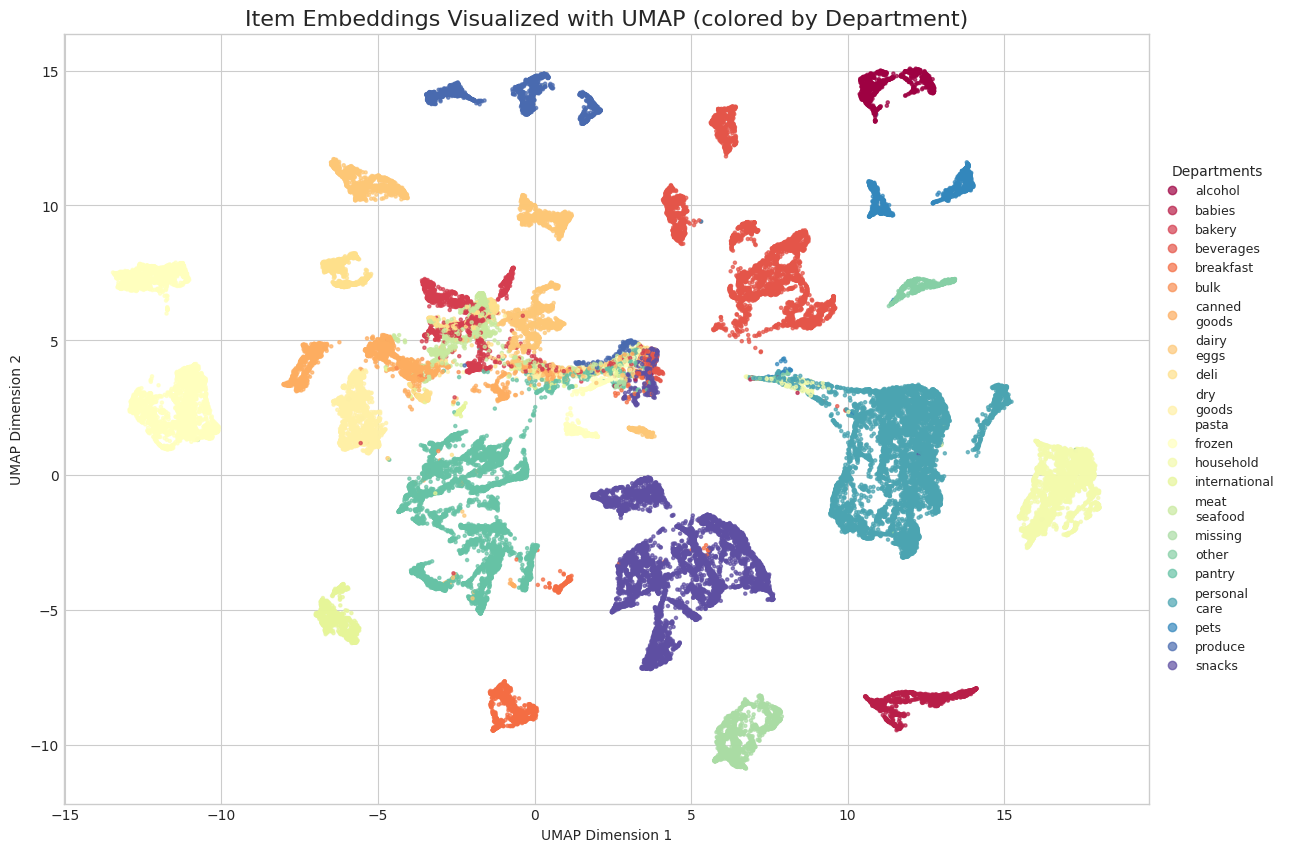

In [10]:
# ベクトル空間が意味のある構造を持っているか確認するため、
# UMAPを使って高次元のアイテムベクトルを2次元に削減し、可視化します。
# departmentごとに色分けすることで、大きなカテゴリでクラスタが形成されているかを確認します。

# UMAPで2次元に次元削減
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(all_item_embeddings)

# department情報を取得
# all_product_idsの順序に合わせてdepartmentを取得
# product_idをキーにした辞書を作成
department_map = original_profiles_df.set_index('product_id')['department'].to_dict()
departments_ordered = [department_map.get(pid, 'unknown') for pid in all_product_ids]

# department名とIDのマッピングを作成
unique_departments = sorted(list(set(departments_ordered)))
department_to_id = {name: i for i, name in enumerate(unique_departments)}
department_ids = [department_to_id[name] for name in departments_ordered]

# プロット
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 10))
scatter = ax.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=department_ids,
    cmap='Spectral', # 色の種類が多いcmapを選択
    s=5,
    alpha=0.7
)

# 凡例を追加
legend_elements = scatter.legend_elements(prop='colors', num=len(unique_departments))
legend_labels = [dept.replace(' ', '\n') for dept in unique_departments]
ax.legend(legend_elements[0], legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Departments", fontsize=9)

plt.title('Item Embeddings Visualized with UMAP (colored by Department)', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()

### 5.複数アイテムからの推薦（カート内推薦）の実行

In [11]:
# ### ---  複数アイテムからの推薦（カート内推薦） ---
# 複数のアイテムがカートにある状況をシミュレートします。
# カート内アイテムのベクトルを平均し、その「カートベクトル」に最も近いアイテムを推薦します。
# これは、「この組み合わせで買っている人は、他に何を買うか？」という問いに答える試みです。

def recommend_for_cart(item_names: List[str], top_k=5) -> Dict[str, Any]:
    """
    カート内のアイテムリストから、次におすすめのアイテムを推薦する。
    結果を辞書形式で返すように変更。
    """
    cart_vectors = []
    input_item_ids = set()
    input_item_names_found = []

    for name in item_names:
        try:
            item_id = original_profiles_df[original_profiles_df['product_name'] == name]['product_id'].iloc[0]
            item_idx = product_id_to_faiss_idx[item_id]
            cart_vectors.append(all_item_embeddings[item_idx])
            input_item_ids.add(item_id)
            input_item_names_found.append(name)
        except (IndexError, KeyError):
            # 警告は返り値に含める
            pass

    # 結果を格納する辞書
    result_data = {
        "input_cart": item_names,
        "found_items": input_item_names_found,
        "recommendations": [],
        "error": None
    }

    if not cart_vectors:
        result_data["error"] = "No valid items found in the cart."
        return result_data

    # カートベクトルの平均を計算
    cart_vector = np.mean(cart_vectors, axis=0, keepdims=True).astype('float32')
    faiss.normalize_L2(cart_vector)

    # 検索実行
    distances, indices = index.search(cart_vector, top_k + len(item_names))

    recommendations_list = []
    for faiss_idx, score in zip(indices[0], distances[0]):
        retrieved_product_id = faiss_idx_to_product_id[faiss_idx]
        if retrieved_product_id not in input_item_ids:
            recommendations_list.append({
                "product_name": product_id_to_name[retrieved_product_id],
                "score": float(score)
            })
        if len(recommendations_list) >= top_k:
            break
            
    result_data["recommendations"] = recommendations_list
    return result_data

In [12]:
# --- 多様な買い物シナリオによる推薦テスト ---

# --- シナリオの定義 ---
# 各シナリオを「名前」「意図」「カートの中身」の辞書として定義
scenarios = [
    # Part 1: 食事の準備
    {"name": "シナリオ1: 自宅で楽しむタコスナイト", "intent": "牛ひき肉とタコスの素を購入。次はサルサやアボカド、トルティーヤなどが期待される。", "cart": ["Ground Beef", "Taco Seasoning Mix", "Shredded Mild Cheddar Cheese"]},
    {"name": "シナリオ2: ヘルシー志向のサラダランチ", "intent": "サラダのベースとなる葉物野菜とトマト、きゅうりを購入。ドレッシングや他のトッピングが期待される。", "cart": ["Organic Baby Spinach", "Grape Tomatoes", "Organic Cucumber"]},
    {"name": "シナリオ3: 定番のミートボールスパゲッティディナー", "intent": "パスタ、ソース、ミートボールが揃っている。粉チーズやパンなどが期待される。", "cart": ["Spaghetti", "Marinara Sauce", "Italian Style Meatballs"]},
    {"name": "シナリオ4: 休日の朝食に、手作りパンケーキ", "intent": "パンケーキミックスとシロップ、卵を購入。バターやフルーツ、牛乳などが期待される。", "cart": ["Pancake & Waffle Mix", "Pure Maple Syrup", "Organic Large Brown Grade AA Cage Free Eggs"]},
    {"name": "シナリオ5: 生地から作る、本格ホームメイドピザ", "intent": "ピザ生地、ソース、チーズをカートに。ペパロニなどのトッピングが期待される。", "cart": ["Pizza Dough", "Pizza Sauce", "Shredded Mozzarella"]},
    {"name": "シナリオ6: アジア風、鶏肉とブロッコリーの炒め物", "intent": "主要な材料である鶏肉、ブロッコリー、醤油を選択。ご飯や他の野菜、ごま油などが期待される。", "cart": ["Boneless Skinless Chicken Breasts", "Broccoli Florets", "Soy Sauce"]},
    {"name": "シナリオ7: 子供と一緒に作る、チョコチップクッキー", "intent": "製菓の基本材料である小麦粉、チョコチップ、砂糖を選択。バターや卵、バニラエッセンスが期待される。", "cart": ["All-Purpose Flour", "Semi-Sweet Chocolate Morsels", "Light Brown Sugar"]},
    {"name": "シナリオ8: カフェ風おしゃれ朝食、アボカドトースト", "intent": "アボカドトーストの主役たち。卵やスパイス、レモンなどが期待される。", "cart": ["Organic Hass Avocado", "100% Whole Wheat Bread"]},
    
    # Part 2: 軽食・パーティー
    {"name": "シナリオ9: 映画鑑賞のお供に、定番スナックとドリンク", "intent": "ポップコーン、コーラ、チョコレート。他のスナック菓子や飲み物が期待される。", "cart": ["Popcorn", "Original Cola", "Milk Chocolate Bar"]},
    {"name": "シナリオ10: ホームパーティーの主役、チップス＆ディップ", "intent": "トルティーヤチップスとサルサ、ワカモレ。チーズディップやサワークリームなどが期待される。", "cart": ["Tortilla Chips", "Salsa", "Guacamole"]},
    {"name": "シナリオ11: ちょっと贅沢な晩酌、チーズとワインのペアリング", "intent": "ブリーチーズとクラッカー、ぶどうを選択。他の種類のチーズや生ハム、ワインが期待される。", "cart": ["Brie Cheese", "Water Crackers", "Seedless Red Grapes"]},
    {"name": "シナリオ12: 夏の風物詩、BBQの基本セット", "intent": "ホットドッグの基本セット。ケチャップやピクルス、ハンバーガー用のパティなどが期待される。", "cart": ["Beef Hot Dogs", "Hot Dog Buns", "Yellow Mustard"]},
    {"name": "シナリオ13: デザートタイムを彩る、アイスクリームサンデー", "intent": "サンデーのベースとトッピング。ホイップクリームやナッツ、チェリーなどが期待される。", "cart": ["Vanilla Bean Ice Cream", "Chocolate Syrup", "Rainbow Sprinkles"]},
    
    # Part 3: 健康・ライフスタイル
    {"name": "シナリオ14: 忙しい朝の栄養補給、フルーツスムージー", "intent": "スムージーの定番材料。ヨーグルトや他のフルーツ、プロテインパウダーなどが期待される。", "cart": ["Banana", "Frozen Organic Strawberries", "Vanilla Almond Milk"]},
    {"name": "シナリオ15: ヴィーガン（完全菜食主義）の食生活基本セット", "intent": "ヴィーガン食のタンパク質源とミルク代替品、野菜。他の植物性食品が期待される。", "cart": ["Organic Tofu", "Unsweetened Almondmilk", "Organic Baby Kale"]},
    {"name": "シナリオ16: 健康を意識した、オーガニック野菜・果物のまとめ買い", "intent": "オーガニックの果物と野菜を複数選択。他のオーガニック製品全般が期待される。", "cart": ["Organic Gala Apples", "Organic Baby Carrots", "Organic Raspberries"]},
    {"name": "シナリオ17: 運動後のタンパク質補給", "intent": "ギリシャヨーグルト、ピーナッツバターなど高タンパクな食品。プロテインドリンクなどが期待される。", "cart": ["Plain Greek Yogurt", "Natural Creamy Peanut Butter", "Chocolate Milk"]},
    {"name": "シナリオ18: グルテンフリー生活のための、パントリー常備品", "intent": "グルテンフリーのスナック。他のグルテンフリー製品が期待される。", "cart": ["Gluten Free Pretzel Twists"]},

    # Part 4: 飲料
    {"name": "シナリオ19: 毎朝の習慣、こだわりのコーヒータイム", "intent": "コーヒー豆とミルク類。コーヒーフィルターや砂糖、他のフレーバーシロップが期待される。", "cart": ["Ground Coffee", "Half & Half", "Organic Whole Milk"]},
    {"name": "シナリオ20: 心を落ち着ける、リラックスティータイム", "intent": "緑茶とはちみつ、レモン。他の種類のハーブティーやビスケットが期待される。", "cart": ["Organic Green Tea", "Honey", "Lemon"]},
    {"name": "シナリオ21: フレーバーウォーターで、おしゃれに水分補給", "intent": "炭酸水とフレーバー用の果物。ミントや他の柑橘類が期待される。", "cart": ["Sparkling Water Grapefruit", "Lime", "Cucumber"]},
    {"name": "シナリオ22: ビール好きのための、クラフトビール飲み比べセット", "intent": "複数のスタイルのビールを選択。おつまみ（ナッツやプレッツェル）や他のビールが期待される。", "cart": ["IPA", "Pilsner", "Chocolate Stout"]},

    # Part 5: その他・生活必需品
    {"name": "シナリオ23: ランチの定番、シンプルなサンドイッチ作り", "intent": "サンドイッチの基本要素。マヨネーズやマスタード、レタスなどが期待される。", "cart": ["Classic White Bread", "Smoked Turkey Breast", "Provolone Cheese Slices"]},
    {"name": "シナリオ24: 体を温める、手作りチキンスープの材料", "intent": "スープのベースと香味野菜。鶏肉やハーブ、麺類などが期待される。", "cart": ["Organic Chicken Broth", "Organic Celery Hearts", "Carrots"]},
    {"name": "シナリオ25: アメリカの朝食の王道、シリアル＆ミルク", "intent": "シリアルと牛乳にバナナを追加。他のフルーツやシリアルが期待される。", "cart": ["Honey Nut Cheerios", "2% Reduced Fat Milk", "Banana"]},
    {"name": "シナリオ26: 赤ちゃんのおむつ交換、必需品セット", "intent": "ベビーケア用品。おしりふきとおむつ。他のケア用品が期待される。", "cart": ["Baby Wipes", "Baby Dry Diapers Size 4"]},
    {"name": "シナリオ27: イタリアン料理の基本、「ソフリット」作り", "intent": "多くの西洋料理のベースとなる香味野菜とオイル。トマト缶やハーブ類が期待される。", "cart": ["Extra Virgin Olive Oil", "Garlic", "Onion"]},
    {"name": "シナリオ28: ヘルシーで美しいデザート、ヨーグルトパフェ", "intent": "パフェのベース。グラノーラや他のフルーツが期待される。", "cart": ["Plain Greek Yogurt", "Organic Blueberries", "Honey"]},
    {"name": "シナリオ29: ホットドッグやハンバーガーに必須の調味料", "intent": "アメリカの食卓に欠かせない調味料。マスタードやBBQソースなどが期待される。", "cart": ["Ketchup", "Mayonnaise", "Sweet Relish"]},
    {"name": "シナリオ30: 愛猫のための、ごはんと特別なおやつ", "intent": "猫用のウェットフード、ドライフード、おやつ。猫砂や他のおもちゃが期待される。", "cart": ["Cat Food", "Chunk Light Tuna in Water", "Party Mix Original Crunch Cat Treats"]},
]

# --- 全シナリオを実行し、結果をリストに格納 ---
execution_results = []
for scenario in tqdm(scenarios, desc="全シナリオを実行中"):
    # 推薦を実行
    result = recommend_for_cart(scenario["cart"])
    
    # シナリオ情報と推薦結果を統合
    full_result = {
        "scenario_name": scenario["name"],
        "intent": scenario["intent"],
        "input_cart": result["input_cart"],
        "found_items_in_cart": result["found_items"],
        "recommendations": result["recommendations"],
        "error": result["error"]
    }
    execution_results.append(full_result)

全シナリオを実行中: 100%|██████████| 30/30 [00:00<00:00, 47.77it/s]


### 6. LLMによる推薦結果の評価

In [13]:
# --- APIキーの設定 ---
api_key = "your-api-key"
genai.configure(api_key=api_key)

In [14]:
# --- LLM の初期化 ---
# 安全設定を調整して、評価がブロックされにくくする
safety_settings = [
    {"category": "HARM_CATEGORY_HARASSMENT", "threshold": "BLOCK_NONE"},
    {"category": "HARM_CATEGORY_HATE_SPEECH", "threshold": "BLOCK_NONE"},
    {"category": "HARM_CATEGORY_SEXUALLY_EXPLICIT", "threshold": "BLOCK_NONE"},
    {"category": "HARM_CATEGORY_DANGEROUS_CONTENT", "threshold": "BLOCK_NONE"},
]
model = genai.GenerativeModel('gemini-2.5-pro', safety_settings=safety_settings)


# --- プロンプトテンプレートの定義 ---
# このテンプレートに各シナリオの結果を埋め込んで使用します。
judge_prompt_template = """
あなたは、Eコマース推薦システムの性能を評価する、冷静かつ客観的な専門家です。
以下の推薦結果データを分析し、Similarity, Diversity, Serendipity, Noveltyの4つの観点から評価してください。
評価は必ずJSON形式で、厳密に指定されたフォーマットに従って出力してください。

# 推薦結果データ:
{scenario_data}

# 評価基準:
 - Similarity (類似性): 推薦されたアイテムは、カートの中身や意図（intent）と文脈的にどの程度類似していますか？ (1: 全く無関係 〜 5: 完璧に一致)
 - Diversity (多様性): 推薦リスト内のアイテムは、互いにどれだけ多様ですか？同じカテゴリのものばかりだと低評価になります。(1: 全く多様でない 〜 5: 非常に多様)
 - Serendipity (セレンディピティ): 推薦は「予期せぬ嬉しい驚き」や「役立つ気づき」をユーザーに与えていますか？ (1: 全くない 〜 5: 非常に高い発見がある)
 - Novelty (新規性): 推薦されたアイテムは、一般的でなく珍しいものですか？定番品ばかりだと低評価になります。(1: 定番品のみ 〜 5: 非常に珍しい)
 - Overall Comment: 評価全体の根拠を簡潔に記述してください。なぜそのスコアになったのかを具体的に説明してください。

# 出力形式 (JSON):
{{
  "similarity_score": <int>,
  "diversity_score": <int>,
  "serendipity_score": <int>,
  "novelty_score": <int>,
  "overall_comment": "<string>"
}}
"""

In [15]:
# --- 全シナリオに対してLLM Judgeを実行 ---
llm_judged_results = []
for scenario in tqdm(execution_results, desc="LLMが各シナリオを評価中"):
    # シナリオデータをJSON文字列に変換
    scenario_json = json.dumps(scenario, indent=2, ensure_ascii=False)
    # プロンプトを生成
    final_prompt = judge_prompt_template.format(scenario_data=scenario_json)
    llm_judgment = None
    try:
        # Gemini APIにリクエストを送信
        response = model.generate_content(final_prompt)

        # レスポンスからJSON部分を抽出してパース
        # LLMは時々 "```json" や "```" をつけてくるので、それらを削除
        cleaned_response_text = response.text.strip().replace("```json", "").replace("```", "")
        llm_judgment = json.loads(cleaned_response_text)

    except Exception as e:
        # エラーが発生した場合（JSONパース失敗、APIエラーなど）
        print(f"\nシナリオ '{scenario['scenario_name']}' の評価中にエラーが発生しました: {e}")
        llm_judgment = {
            "error": str(e),
            "raw_response": response.text if 'response' in locals() else "No response"
        }

    # 元のシナリオデータとLLMの評価結果をマージ
    judged_result = {**scenario, "llm_judgment": llm_judgment}
    llm_judged_results.append(judged_result)

    # APIのレートリミットを避けるための短い待機
    time.sleep(1)

LLMが各シナリオを評価中: 100%|██████████| 30/30 [11:40<00:00, 23.34s/it]


In [16]:
# 各指標の平均スコア
mean_similarity_score = sum([llm_judged_result["llm_judgment"]["similarity_score"] for llm_judged_result in llm_judged_results]) / len(llm_judged_results)
mean_diversity_score = sum([llm_judged_result["llm_judgment"]["diversity_score"] for llm_judged_result in llm_judged_results]) / len(llm_judged_results)
mean_serendipity_score = sum([llm_judged_result["llm_judgment"]["serendipity_score"] for llm_judged_result in llm_judged_results]) / len(llm_judged_results)
mean_novelty_score = sum([llm_judged_result["llm_judgment"]["novelty_score"] for llm_judged_result in llm_judged_results]) / len(llm_judged_results)

print(f"mean_similarity_score: {mean_similarity_score:.2f}")
print(f"mean_diversity_score: {mean_diversity_score:.2f}")
print(f"mean_serendipity_score: {mean_serendipity_score:.2f}")
print(f"mean_novelty_score: {mean_novelty_score:.2f}")

mean_similarity_score: 3.20
mean_diversity_score: 2.53
mean_serendipity_score: 1.63
mean_novelty_score: 1.43


In [17]:
# --- 総合評価レポート生成 ---

# LLMに渡すため、個別の評価結果をサマリー形式に整形
# 全ての詳細を送るとトークン数を超える可能性があるため、要点のみを抽出
summary_for_final_report = []
for result in llm_judged_results:
    if result.get("llm_judgment") and "error" not in result["llm_judgment"]:
        summary_for_final_report.append({
            "scenario_name": result["scenario_name"],
            "input_cart": result["input_cart"],
            "recommendations": [item["product_name"] for item in result["recommendations"]],
            "scores": {
                "similarity": result["llm_judgment"]["similarity_score"],
                "diversity": result["llm_judgment"]["diversity_score"],
                "serendipity": result["llm_judgment"]["serendipity_score"],
                "novelty": result["llm_judgment"]["novelty_score"],
            },
            "judge_comment": result["llm_judgment"]["overall_comment"]
        })

# --- 総合評価プロンプトの定義 ---
final_report_prompt_template = """
あなたは、推薦モデルの評価結果を分析しレポートを作成する経験豊富なデータサイエンティストです。

以下のデータは、30個のシナリオに対する推薦モデルから得られた個別の評価結果のリストです。
このデータ全体を俯瞰し、以下の構成で総合的な評価レポートを生成してください。
レポートは、専門的かつ分かりやすい言葉で記述してください。

# 個別評価データ:
{individual_evaluations}

# レポート構成:
エグゼクティブサマリー (Executive Summary):
この推薦モデルの全体的な性能と、最も顕著な特徴を2〜3文で要約してください。

顕著な強み (Key Strengths):
このモデルが特に優れている点を2つ挙げてください。具体的なシナリオ名や評価コメントを引用し、その強みがなぜ重要なのかを説明してください。

明確な弱点と課題 (Clear Weaknesses and Challenges):
このモデルが抱える最も大きな課題を2つ挙げてください。同様に、具体的なシナリオ名や評価コメントを引用し、その原因を推測してください。

推薦の質の分析 (Analysis of Recommendation Quality):

多様性 (Diversity): モデルの推薦は多様性に富んでいますか？ 全体的な傾向を述べてください。

セレンディピティと新規性 (Serendipity & Novelty): ユーザーに「嬉しい驚き」や「新しい発見」を提供する能力はありますか？ 興味深い事例があれば言及してください。

総括と今後の展望 (Conclusion and Future Directions):
総合的に見て、このモデルは実用的な価値がありますか？
また、今回明らかになった課題を解決するために、次にどのような改善アプローチが考えられるかを提案してください。
"""
# --- 総合評価レポートの生成を実行 ---
# 評価サマリーをJSON文字列に変換
evaluations_json = json.dumps(summary_for_final_report, indent=2, ensure_ascii=False)

# プロンプトを生成
final_prompt = final_report_prompt_template.format(individual_evaluations=evaluations_json)

# Gemini APIにリクエストを送信
final_report_response = model.generate_content(final_prompt)
print("\n" + "="*80)
print(" " * 28 + "総合評価レポート (LLMによる生成)")
print("="*80)
display(Markdown(final_report_response.text))


                            総合評価レポート (LLMによる生成)


## 推薦モデル評価分析レポート

### エグゼクティブサマリー (Executive Summary)

本推薦モデルは、ユーザーの意図が明確な一部のシナリオにおいて高い関連性を示す潜在能力を持つ一方で、多くのケースで文脈や制約の理解に失敗し、致命的に不適切な推薦を生成しています。特に、推薦内容が単一カテゴリに著しく偏る「多様性の欠如」が最大の課題であり、現状のままではユーザー体験を損なうリスクが高く、広範な実用化は困難であると結論付けられます。

### 顕著な強み (Key Strengths)

分析の結果、本モデルには以下の2つの優れた点が確認されました。

1.  **特定カテゴリにおけるユーザー嗜好の深掘り**
    モデルは、ユーザーの嗜好が明確な特定のカテゴリにおいて、関連性を維持しつつ、より専門的または多様な選択肢を提示する能力を示しました。
    *   **具体例:** `シナリオ22: ビール好きのための、クラフトビール飲み比べセット` では、カート内のIPAに対し「West Coast Double India Pale Ale Beer」を推薦するなど、「ユーザーの好みを深掘りする提案は、セレンディピティの観点から高く評価できる」と判断されています。
    *   **重要性:** この能力は、ユーザーの満足度を高め、専門性の高いカテゴリにおける信頼を構築する上で不可欠です。単なる類似品に留まらず、ユーザーの知識や体験を拡張する質の高い推薦と言えます。

2.  **関連性と発見のバランスが取れた推薦の生成**
    ごく一部の成功事例ではありますが、モデルはユーザーの主要な目的から逸脱することなく、新しい発見や意外性のあるアイテムを提示できています。
    *   **具体例:** `シナリオ9: 映画鑑賞のお供に、定番スナックとドリンク` では、定番のスナックに加えて「Sea Salt Adzuki Bean Crackers（あずきクラッカー）」といった意外性のある商品を推薦。「ユーザーの期待に応えつつ、新しい選択肢を提示するバランスの取れた推薦」と高く評価されました。
    *   **重要性:** このような推薦は、ユーザーに「嬉しい驚き」を提供し、購買体験をより豊かにします。これは、モデルが目指すべき理想的な推薦の形を示す貴重な成功事例です。

### 明確な弱点と課題 (Clear Weaknesses and Challenges)

一方で、モデルの性能を著しく低下させている、以下の2つの深刻な課題が明らかになりました。

1.  **文脈および暗黙的な制約の完全な無視**
    モデルは、カート内のアイテムから推測されるユーザーの「目的」や「制約」を理解できず、ユーザーの期待を根本から裏切る推薦を頻発させています。
    *   **具体例:** `シナリオ15: ヴィーガン` で魚介類を推薦、`シナリオ18: グルテンフリー` でグルテンフリーでない商品を推薦、`シナリオ30: 愛猫のため` のシナリオで「すべて『犬用』」商品を推薦するなど、致命的なエラーが多数確認されました。これらのコメントには「明確な意図を完全に無視」「ユーザーの意図を致命的に誤解した」と記されており、問題の深刻さを示しています。
    *   **原因推測:** これは、アイテム間の表層的な共起性や類似性のみに依存したアルゴリズム（例：単純なItem-to-Item協調フィルタリング）が用いられている可能性を示唆します。「ヴィーガン」や「猫用」といったセマンティックな（意味的な）情報をモデルが扱えていないと考えられます。

2.  **過度な類似性への依存と多様性の著しい欠如**
    多くのシナリオで、推薦がカート内の特定アイテムの「代替品」や「類似品」に終始しており、ユーザーが本来求めているであろう「補完品（クロスセル）」を提案できていません。
    *   **具体例:** `シナリオ8: アボカドトースト` でパンとアボカドの代替品ばかりを推薦、`シナリオ26: 赤ちゃんのおむつ交換` でおむつとおしりふきのバリエーションのみを推薦するなど、多様性スコアが「1」と評価されたシナリオが多数存在します。コメントには「アイテムベースの類似性に過度に依存した推薦」「クロスセルの機会を逃した」といった指摘が見られます。
    *   **原因推測:** モデルが単一アイテムの類似度スコアに過度に最適化されており、推薦リスト全体としてのバランスを考慮する仕組み（例：リランキング処理）が欠如している可能性があります。結果として、ユーザーの購買体験を広げる機会を逸しています。

### 推薦の質の分析 (Analysis of Recommendation Quality)

#### 多様性 (Diversity)
全体として、本モデルの推薦における**多様性は極めて低い**傾向にあります。多くの成功シナリオでさえ、「推薦が全て『野菜』という単一カテゴリに集中している」（`シナリオ24`）といった評価が見られ、モデルの根本的な弱点であることがうかがえます。
興味深いことに、`シナリオ1: タコスナイト` のように文脈を完全に無視した結果、多様性スコアが「4」と高くなっているケースも存在します。これは見せかけの多様性であり、関連性のないアイテムを無秩序に並べた結果に過ぎず、「質の悪い多様性」の典型例です。意図的に関連性を保ちながら多様なアイテムを推薦する能力は、本モデルに欠けていると言えます。

#### セレンディピティと新規性 (Serendipity & Novelty)
ユーザーに「嬉しい驚き」や「新しい発見」を提供する能力は、**全体として非常に低い**です。これは前述の多様性の欠如と密接に関連しており、予測可能な代替品ばかりでは驚きは生まれません。
ただし、`シナリオ19: こだわりのコーヒータイム` において、バターコーヒーを想起させる「Pure Irish Butter」を推薦した点は、ユーザーに新しい習慣を提案する可能性を秘めた興味深い事例です。このような「役立つ発見」に繋がる推薦を安定して生成することが、今後の大きな目標となります。

### 総括と今後の展望 (Conclusion and Future Directions)

総合的に見て、本推薦モデルは**現状のままでは実用的な価値が低い**と判断します。特に、アレルギーや食生活の制約、ペットの種類といった、誤りが許されないシナリオでの致命的な失敗は、ユーザーの信頼を完全に失わせるリスクをはらんでいます。

この評価結果を踏まえ、以下のような改善アプローチを提案します。

1.  **コンテキスト理解能力の抜本的強化:**
    *   商品名や商品説明文などのテキスト情報を活用し、アイテムの意味内容を捉える自然言語処理モデル（例：BERT等を用いたアイテム埋め込み）を導入します。これにより、「ヴィーガン」や「グルテンフリー」といったキーワードをモデルが理解できるようになります。
    *   「レシピ」や「用途」といったメタデータを活用し、アイテム間の補完関係（例：「パスタ」と「パスタソース」）を学習させることで、クロスセル性能の向上を目指します。

2.  **多様性とセレンディピティを制御する仕組みの導入:**
    *   推薦候補を生成した後、関連性と多様性のバランスを取りながらリストを並べ替える**リランキング処理**（例：Maximal Marginal Relevanceアルゴリズム）を導入します。これにより、「牛乳の類似品ばかり」といった偏りを抑制します。
    *   ユーザーの過去の購買履歴から少し離れたアイテムや、新商品などを意図的に推薦に混ぜ込む**探索的アプローチ**を取り入れ、セレンディピティの向上を図ります。

本評価により、モデルの明確な強みと深刻な課題が浮き彫りになりました。上記改善策を着実に実行し、今回のようなシナリオベースの定性評価を継続することで、モデルをより信頼性が高く、実用的なレベルへと引き上げることが可能であると考えます。

In [18]:
# 結果詳細
llm_judged_results

[{'scenario_name': 'シナリオ1: 自宅で楽しむタコスナイト',
  'intent': '牛ひき肉とタコスの素を購入。次はサルサやアボカド、トルティーヤなどが期待される。',
  'input_cart': ['Ground Beef',
   'Taco Seasoning Mix',
   'Shredded Mild Cheddar Cheese'],
  'found_items_in_cart': ['Ground Beef',
   'Taco Seasoning Mix',
   'Shredded Mild Cheddar Cheese'],
  'recommendations': [{'product_name': 'Extra Wide Egg Noodles',
    'score': 0.9902915358543396},
   {'product_name': 'Natural Fresh Goat Cheese', 'score': 0.9902353882789612},
   {'product_name': 'Ricotta Cheese', 'score': 0.9901198744773865},
   {'product_name': 'Chicken Tenders', 'score': 0.9898371696472168},
   {'product_name': 'Lightly Smoked Sardines in Olive Oil',
    'score': 0.9896779656410217}],
  'error': None,
  'llm_judgment': {'similarity_score': 1,
   'diversity_score': 4,
   'serendipity_score': 1,
   'novelty_score': 1,
   'overall_comment': 'この推薦はユーザーの意図「タコスナイト」を全く理解しておらず、Similarity（類似性）が致命的に低い。カート内の商品や期待されるアイテム（サルサ、トルティーヤ等）との関連性が皆無である。推薦リストはチーズ、麺、鶏肉、魚と多様性（Diversity）こそ高いものの、それは文脈